# Data Scientist Challenge - LATAM Airlines
### Matias Bustamante

In [155]:
# Importación de librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from funpymodeling.exploratory import freq_tbl
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score,classification_report,recall_score,roc_auc_score,precision_score,f1_score,confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix

In [235]:
#Funcion que sirve de herramienta para imprimir los resultados de diferentes modelos y crear una tabla comparativa entre ellos
#Esta funcion ha sido usada previamente en otros proyectos. Ademas de utilizar el modelo y sus parametros, tambien
# se le puede entregar el nombre del modelo, si se desea añadir a la tabla resumen y si la evaluación es para el conjunto
# entrenamiento o el conjunto de prueba.
log=[["Modelo","Precision","Roc"]]
def print_score(clf, X_train, y_train, X_test, y_test,modelo,add=True,train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        precision_tr = accuracy_score(y_train, pred) * 100
        print("Data entrenamiento:\n")
        print("Precision --->",precision_tr,"%")
        print("Reporte completo\n", clf_report)
        print("Matriz de confusión:\n",confusion_matrix(y_train, pred))
        print("Roc score --->",roc_auc_score(y_train,pred)) 
        print("Acc score --->",accuracy_score(y_train,pred)) 
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        precision_ts = accuracy_score(y_test, pred) * 100
        print("Data test:\n")
        print("Precision --->",precision_ts,"%")
        print("Reporte completo\n", clf_report)
        print("Matriz de confusión:\n",confusion_matrix(y_test, pred))
        print("Roc score --->",roc_auc_score(y_test,pred))
        print("Acc score --->",accuracy_score(y_test,pred)) 
        if add ==True:
            log.append([modelo,precision_ts,roc_auc_score(y_test, pred)])
            
def plotHistogram(df, histsh, histrow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]]
    nRow, nCol = df.shape
    columnNames = list(df)
    nHistRow = (nCol + histrow - 1) / histrow
    plt.figure(num=None, figsize=(6*histrow, 8*nHistRow), dpi=80, facecolor='w', edgecolor='k')
    for i in range(min(nCol, histsh)):
        plt.subplot(nHistRow, histrow, i+1)
        df.iloc[:,i].hist()
        plt.ylabel('counts')
        plt.xticks(rotation=90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    plt.show()

In [57]:
#Funciones para calcular tasas con respecto a las diferentes variables solicitadas en el desafio.

def frecuencia_atraso(data, col, destino, dif_min):
    indice_col = data.columns.get_loc(col)
    indice_dif_min = data.columns.get_loc(dif_min)
    cont = 0
    for indice in range(data.shape[0]):
        if(data.iloc[indice, indice_col] == destino) & (data.iloc[indice, indice_dif_min] > 15):  
            cont+=1        
    return cont

def cantidad(data, col, variable):
    indice_col = data.columns.get_loc(col)
    cont = 0
    for indice in range(data.shape[0]):
        if(data.iloc[indice, indice_col] == variable):
            cont+=1     
    return cont

def tasa_ocurrencia(data, col, destino, dif_min):  
    indice_col = data.columns.get_loc(col)
    indice_dif_min = data.columns.get_loc(dif_min) 
    cont = 0 
    for indice in range(data.shape[0]):
        if(data.iloc[indice, indice_col] == destino):
            cont+=1
    aux = frecuencia_atraso(data, col, destino, dif_min)
    return aux/cont

def calculo_tasas(data, lista, col):
    valores = []
    atrasos = []
    cantidad_total = []
    for indice in range(len(lista)):
        valores.append(tasa_ocurrencia(data, col, lista[indice], 'dif_min'))
        atrasos.append(frecuencia_atraso(data, col, lista[indice],'dif_min'))
        cantidad_total.append(cantidad(data, col, lista[indice]))
        
    return valores, atrasos, cantidad_total

In [140]:
#Carga y lectura del dataset
data = pd.read_csv("dataset_SCL.csv", low_memory=False)

# Pre-procesamiento dataset + feature engeeniering# 

In [141]:
import numpy as np
#Transformación de las fechas a tipo datetime
data['Fecha-I'] =  pd.to_datetime(data['Fecha-I'])
data['Fecha-O'] =  pd.to_datetime(data['Fecha-O'])

In [142]:
#Columna de la diferencia de los minutos con respecto a la fecha de operacion y de i
data['dif_min'] = (data['Fecha-O']-data['Fecha-I']).astype('timedelta64[m]')
data['dif_min'].value_counts()

 0.0      4789
-1.0      4026
 1.0      3921
 2.0      3622
-2.0      3582
          ... 
 141.0       5
 136.0       4
 146.0       4
 149.0       4
 139.0       3
Name: dif_min, Length: 176, dtype: int64

In [143]:
#Creación columna temporada_alta respecto los requisitos indicados
data['temporada_alta'] = np.where(data['MES'] == 12, 1, 0) & np.where(data['DIA'] >= 15, 1, 0) 
data['temporada_alta'] = np.where(data['MES'] == 1, 1, data['temporada_alta']) | np.where(data['MES'] == 2, 1, data['temporada_alta'])
data['temporada_alta'] = np.where(data['MES'] == 3, 1, data['temporada_alta']) & np.where(data['DIA'] <= 3, 1, data['temporada_alta'])
data['temporada_alta'] = np.where(data['MES'] == 7, 1, data['temporada_alta']) & np.where(data['DIA'] >= 15, 1, data['temporada_alta']) & np.where(data['DIA'] <= 31, 1, data['temporada_alta'])
data['temporada_alta'] = np.where(data['MES'] == 9, 1, data['temporada_alta']) & np.where(data['DIA'] >= 11, 1, data['temporada_alta']) & np.where(data['DIA'] <= 30, 1, data['temporada_alta'])
data['temporada_alta'].value_counts()

0    45444
1    22762
Name: temporada_alta, dtype: int64

In [144]:
# Creación Columna si existió o no existió atraso.
data['atraso_15'] = np.where(data['dif_min'] > 15, True, False)
data['atraso_15'].value_counts()

False    55592
True     12614
Name: atraso_15, dtype: int64

In [145]:
#Creación variable periodo_dia

data['periodo_dia'] = data['Fecha-I'].dt.hour
data['periodo_dia'] = np.where((data['Fecha-I'].dt.hour >= 5) & (data['Fecha-I'].dt.hour< 12),"mañana", data['periodo_dia'])
data['periodo_dia'] = np.where((data['Fecha-I'].dt.hour >= 12) & (data['Fecha-I'].dt.hour< 19),"tarde", data['periodo_dia'])
data['periodo_dia'] = np.where((data['Fecha-I'].dt.hour >= 19) & (data['Fecha-I'].dt.hour< 24),"noche", data['periodo_dia'])
data['periodo_dia'] = np.where((data['Fecha-I'].dt.hour >= 0) & (data['Fecha-I'].dt.hour< 5),"noche", data['periodo_dia'])
data['periodo_dia'].value_counts()

tarde     25506
mañana    25352
noche     17348
Name: periodo_dia, dtype: int64

In [146]:
# Exportamos el dataset en formato archivo a modo de satisfacer la petición del documento.
data.to_csv('synthetic_features.csv') 

In [147]:
#Creación variable holiday (si es fin de semana)

data['holiday'] = np.where(data['DIANOM'] == "Sabado", 1, 0)
data['holiday'] = np.where(data['DIANOM'] == "Domingo", 1, data['holiday'])
data['holiday'].value_counts()

0    50058
1    18148
Name: holiday, dtype: int64

In [148]:
#Creación variable nombre mes para un gráfico

data['MESNOM'] = data['Fecha-I'].dt.month

dict = {"Enero" : '1',"Febrero" : '2',"Marzo" : '3',"Abril" : '4',"Mayo" : '5',"Junio" : '6',"Julio" : '7',"Agosto": '8',"Septiembre" : '9',"Octubre" : '10',"Noviembre" : '11',"Diciembre" : '12'}
lista=["0","Enero","Febrero","Marzo","Abril","Mayo","Junio","Julio","Agosto","Septiembre","Octubre","Noviembre","Diciembre"]
#dict = {"1" : 'Enero',"2" : 'Febrero',"3" : 'Marzo',"4" : 'Abril',"5" : 'Mayo',"6" : 'Junio',"7" : 'Julio',"8": 'Agosto',"9" : 'Septiembre',"10" : 'Octubre',"11" : 'Noviembre',"12" : 'Diciembre'}
# por alguna razon el remplazo por diccionario no dio resultaedo, en son de ahorrar tiempo se remplaza de manera estandar.

data['MESNOM'] = np.where(data['Fecha-I'].dt.month == 1,"Enero", data['MESNOM'])
for i in range(len(lista)):
    data['MESNOM'] = np.where(data['Fecha-I'].dt.month == i,lista[i], data['MESNOM'])
    
data['MESNOM'].value_counts()

Diciembre     6357
Enero         6108
Noviembre     6081
Octubre       6032
Julio         5991
Agosto        5744
Septiembre    5610
Febrero       5561
Marzo         5480
Mayo          5239
Abril         5021
Junio         4982
Name: MESNOM, dtype: int64

# Analisis exploratorio

In [44]:
print(data.shape)

(68206, 23)


In [45]:
data.head(5)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,temporada_alta,dif_min,atraso_15,holiday,periodo_dia
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,Domingo,I,American Airlines,Santiago,Miami,1,3.0,False,1,noche
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,Lunes,I,American Airlines,Santiago,Miami,1,9.0,False,0,noche
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,Martes,I,American Airlines,Santiago,Miami,1,9.0,False,0,noche
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,Miercoles,I,American Airlines,Santiago,Miami,1,3.0,False,0,noche
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,Jueves,I,American Airlines,Santiago,Miami,1,-2.0,False,0,noche


In [46]:
data.columns

Index(['Fecha-I', 'Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O',
       'Ori-O', 'Des-O', 'Emp-O', 'DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO',
       'OPERA', 'SIGLAORI', 'SIGLADES', 'temporada_alta', 'dif_min',
       'atraso_15', 'holiday', 'periodo_dia'],
      dtype='object')

In [47]:
data.describe()

,DIA,MES,AÑO,temporada_alta,dif_min,holiday
count,68206.000000,68206.000000,68206.000000,68206.000000,68206.000000,68206.000000
mean,15.714790,6.622585,2017.000029,0.333724,9.110855,0.266076
std,8.782886,3.523321,0.005415,0.471546,19.313387,0.441908
min,1.000000,1.000000,2017.000000,0.000000,-14.000000,0.000000
25%,8.000000,3.000000,2017.000000,0.000000,-1.000000,0.000000
50%,16.000000,7.000000,2017.000000,0.000000,4.000000,0.000000
75%,23.000000,10.000000,2017.000000,1.000000,12.000000,1.000000
max,31.000000,12.000000,2018.000000,1.000000,161.000000,1.000000


In [48]:
data.isnull().sum()

Fecha-I           0
Vlo-I             0
Ori-I             0
Des-I             0
Emp-I             0
Fecha-O           0
Vlo-O             1
Ori-O             0
Des-O             0
Emp-O             0
DIA               0
MES               0
AÑO               0
DIANOM            0
TIPOVUELO         0
OPERA             0
SIGLAORI          0
SIGLADES          0
temporada_alta    0
dif_min           0
atraso_15         0
holiday           0
periodo_dia       0
dtype: int64

In [49]:
#Eliminación de nulos
data = data.dropna()
print(data.shape)

(68205, 23)


In [52]:
week = data[['DIANOM','atraso_15']].groupby('DIANOM').sum().sort_values(by='atraso_15',ascending=False)
week['PERCENTUAL'] = week['atraso_15']/(week['atraso_15'].sum())*100
print('Atrasos por día')
print(week)

month = data[['DIA','atraso_15']].groupby('DIA').sum().sort_values(by='atraso_15',ascending=False)
month['PERCENTUAL'] = month['atraso_15']/(month['atraso_15'].sum())*100

print('\n')
print('Atrasos por mes del día')
print(month)

Atrasos por día
           atraso_15  PERCENTUAL
DIANOM                          
Viernes         2285   18.114793
Lunes           2048   16.235928
Jueves          2045   16.212145
Miercoles       1661   13.167909
Martes          1634   12.953861
Domingo         1578   12.509910
Sabado          1363   10.805454


Atrasos por mes del día
     atraso_15  PERCENTUAL
DIA                       
15         544    4.312668
11         520    4.122404
10         515    4.082765
16         468    3.710163
26         453    3.591248
20         449    3.559537
14         449    3.559537
6          449    3.559537
12         436    3.456477
22         436    3.456477
17         435    3.448549
21         434    3.440622
4          420    3.329634
13         413    3.274140
18         412    3.266212
23         406    3.218646
25         400    3.171080
3          400    3.171080
9          397    3.147297
5          391    3.099730
19         391    3.099730
24         383    3.036309
28         37

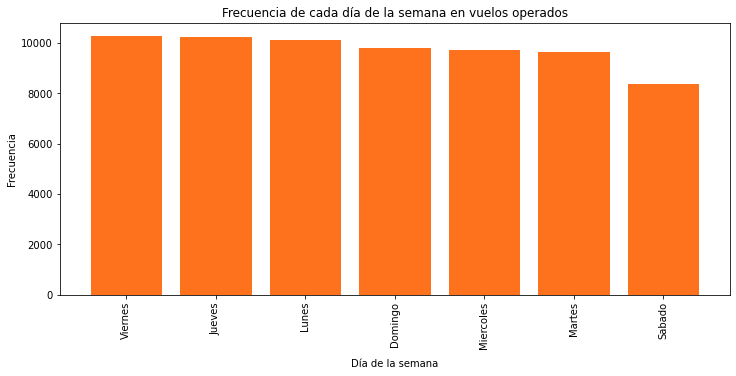

,DIANOM,frequency,percentage,cumulative_perc
0,Viernes,10292,0.150898,0.150898
1,Jueves,10250,0.150282,0.301180
2,Lunes,10131,0.148537,0.449718
3,Domingo,9796,0.143626,0.593344
4,Miercoles,9722,0.142541,0.735884
5,Martes,9662,0.141661,0.877546
6,Sabado,8352,0.122454,1.000000


In [51]:
dia_O = freq_tbl(data['DIANOM'])
plt.figure(figsize=(12,5))
plt.bar(dia_O['DIANOM'],dia_O['frequency'], color = '#ff721d')
plt.xticks(rotation = 90)
plt.xlabel('Día de la semana', labelpad=10)
plt.ylabel('Frecuencia')
plt.title('Frecuencia de cada día de la semana en vuelos operados')
plt.show()
dia_O

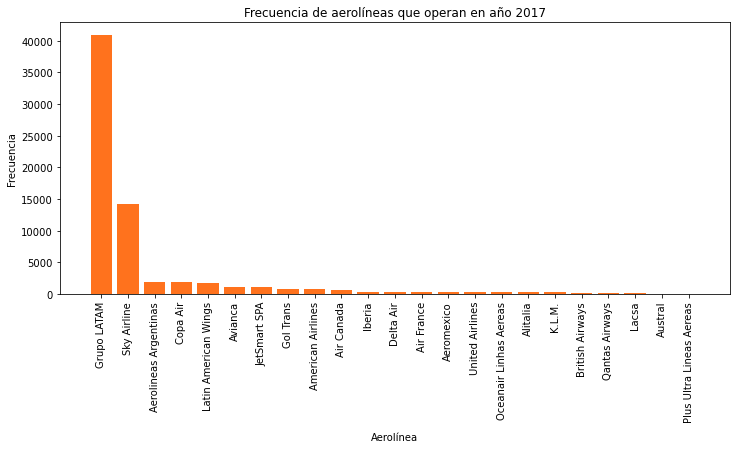

,OPERA,frequency,percentage,cumulative_perc
0,Grupo LATAM,40892,0.599545,0.599545
1,Sky Airline,14298,0.209633,0.809178
2,Aerolineas Argentinas,1949,0.028576,0.837754
3,Copa Air,1850,0.027124,0.864878
4,Latin American Wings,1673,0.024529,0.889407
5,Avianca,1152,0.016890,0.906297
6,JetSmart SPA,1095,0.016055,0.922352
7,Gol Trans,806,0.011817,0.934169
8,American Airlines,757,0.011099,0.945268
9,Air Canada,565,0.008284,0.953552


In [50]:
opera = freq_tbl(data['OPERA'])
plt.figure(figsize=(12,5))
plt.bar(opera['OPERA'],opera['frequency'], color = '#ff721d')
plt.xticks(rotation = 90)
plt.xlabel('Aerolínea', labelpad=10)
plt.ylabel('Frecuencia')
plt.title('Frecuencia de aerolíneas que operan en año 2017')
plt.show()
opera

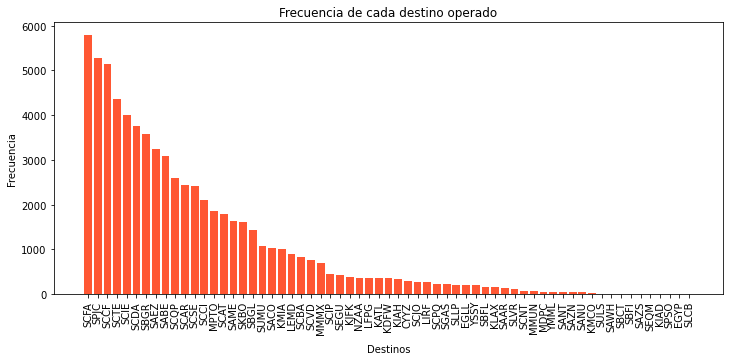

,Des-O,frequency,percentage,cumulative_perc
0,SCFA,5786,0.084832,0.084832
1,SPJC,5269,0.077252,0.162085
2,SCCF,5146,0.075449,0.237534
3,SCTE,4357,0.063881,0.301415
4,SCIE,3993,0.058544,0.359959
...,...,...,...,...
58,SEQM,2,0.000029,0.999941
59,KIAD,1,0.000015,0.999956
60,SPSO,1,0.000015,0.999971
61,EGYP,1,0.000015,0.999985


In [53]:
destinos_O = freq_tbl(data['Des-O'])
plt.figure(figsize=(12,5))
plt.bar(destinos_O['Des-O'],destinos_O['frequency'], color = '#FF5733')
plt.xticks(rotation = 90)
plt.xlabel('Destinos', labelpad=10)
plt.ylabel('Frecuencia')
plt.title('Frecuencia de cada destino operado')
plt.show()
destinos_O

<AxesSubplot:xlabel='atraso_15', ylabel='count'>

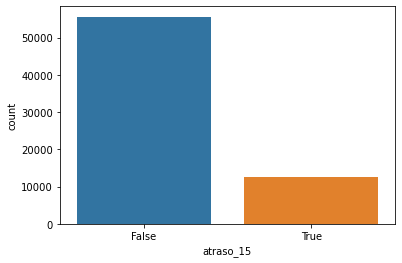

In [54]:
sns.countplot(data['atraso_15'])

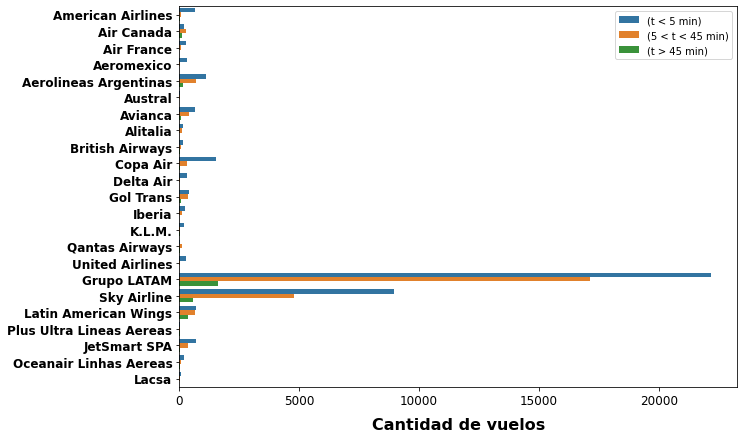

In [55]:
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
data['DELAY_LEVEL'] = data['dif_min'].apply(delay_type)
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="OPERA", hue='DELAY_LEVEL', data=data)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Cantidad de vuelos', fontsize=16, weight = 'bold', labelpad=10)


L = plt.legend()
L.get_texts()[0].set_text('(t < 5 min)')
L.get_texts()[1].set_text('(5 < t < 45 min)')
L.get_texts()[2].set_text('(t > 45 min)')
plt.show()

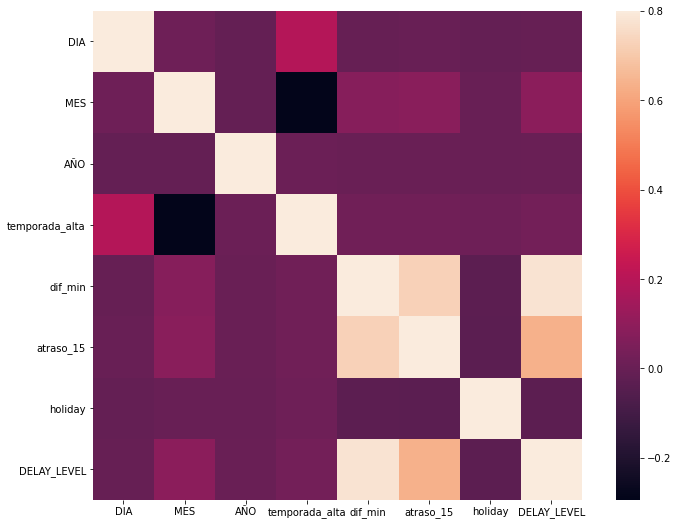

In [56]:
corrmat = data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.show()

## Observación de tasas

In [58]:
destinos = data['Des-I'].unique().tolist()
valores, atrasos, cantidad_total = calculo_tasas(data, destinos,'Des-I')
des_i = pd.DataFrame({
    'Destino':destinos,
    'Cant. de vuelos':cantidad_total,
    'Cant de vuelos atrasados':atrasos,
    'Tasa':valores
})
des_i

,Destino,Cant. de vuelos,Cant de vuelos atrasados,Tasa
0,KMIA,1015,193,0.190148
1,KDFW,357,25,0.070028
2,SAEZ,3240,790,0.243827
3,CYYZ,283,89,0.314488
4,LFPG,359,31,0.086351
...,...,...,...,...
59,SAWH,6,4,0.666667
60,EGYP,1,1,1.000000
61,SULS,6,1,0.166667
62,SLCB,1,1,1.000000


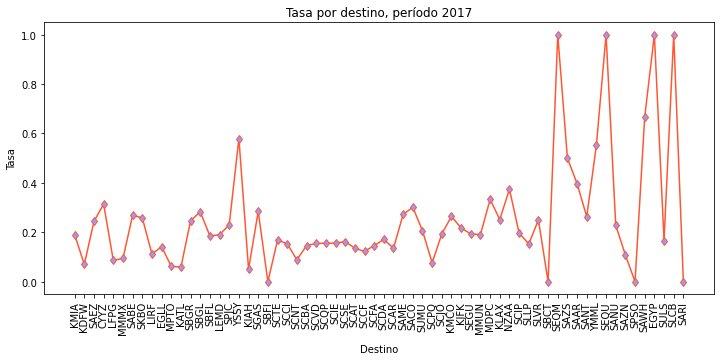

In [61]:
plt.figure(figsize=(12,5))
plt.plot(des_i['Destino'],des_i['Tasa'],marker='d',linestyle='-', c = '#FF5733',markeredgecolor='#FF5733',markerfacecolor='#9999ff')
plt.xticks(rotation = 90)
plt.xlabel('Destino', labelpad=10)
plt.ylabel('Tasa')
plt.title('Tasa por destino, período 2017')
plt.show()

In [128]:
aerolineas = data['Emp-I'].unique().tolist()
valores, atrasos, cantidad_total = calculo_tasas(data, aerolineas,'Emp-I')
aerolineas = pd.DataFrame({
    'Aerolínea':aerolineas,
    'Cant. de vuelos':cantidad_total,
    'Cant de vuelos atrasados':atrasos,
    'Tasa':valores
})
aerolineas

,Aerolínea,Cant. de vuelos,Cant de vuelos atrasados,Tasa
0,AAL,757,51,0.067371
1,ACA,565,258,0.456637
2,AFR,358,30,0.083799
3,AMX,351,10,0.028490
4,ARG,1949,468,0.240123
5,AUT,74,15,0.202703
6,AVA,1152,306,0.265625
7,AZA,259,29,0.111969
8,BAW,205,29,0.141463
9,CMP,1850,116,0.062703


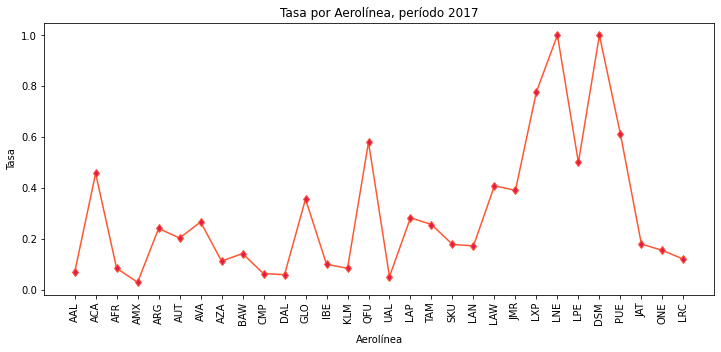

In [129]:
plt.figure(figsize=(12,5))
plt.plot(aerolineas['Aerolínea'],aerolineas['Tasa'],marker='d',linestyle='-', c = '#FF5733',markeredgecolor='#FF5733',markerfacecolor='#e51a4c')
plt.xticks(rotation = 90)
plt.xlabel('Aerolínea', labelpad=10)
plt.ylabel('Tasa')
plt.title('Tasa por Aerolínea, período 2017')
plt.show()

In [130]:
meses = data['MESNOM'].unique().tolist()
valores, atrasos, cantidad_total = calculo_tasas(data, meses,'MESNOM')
mes_tasa = pd.DataFrame({
    'Mes':meses,
    'Cant. de vuelos':cantidad_total,
    'Cant de vuelos atrasados':atrasos,
    'Tasa':valores
})
mes_tasa

,Mes,Cant. de vuelos,Cant de vuelos atrasados,Tasa
0,Enero,6107,979,0.160308
1,Febrero,5561,843,0.151591
2,Marzo,5480,629,0.114781
3,Abril,5021,586,0.116710
4,Mayo,5239,826,0.157664
5,Junio,4982,852,0.171016
6,Julio,5991,1758,0.293440
7,Agosto,5744,996,0.173398
8,Septiembre,5610,967,0.172371
9,Octubre,6032,1363,0.225962


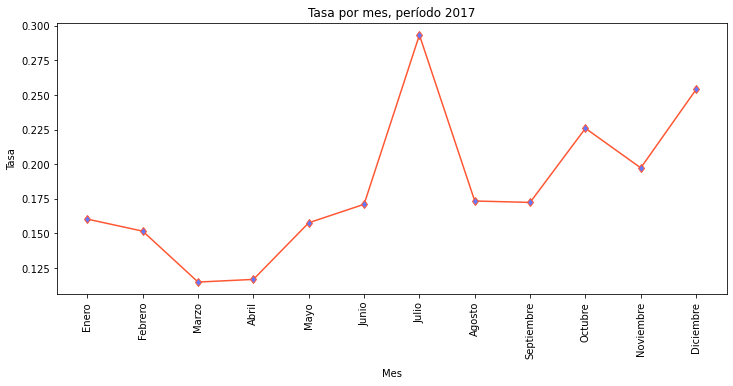

In [131]:
plt.figure(figsize=(12,5))
plt.plot(mes_tasa['Mes'],mes_tasa['Tasa'],marker='d',linestyle='-', c = '#FF5733',markeredgecolor='#FF5733',markerfacecolor= '#6378ff')
plt.xticks(rotation = 90)
plt.xlabel('Mes', labelpad=10)
plt.ylabel('Tasa')
plt.title('Tasa por mes, período 2017')
plt.show()

 Es de interes observar que a pesar de existir distintas temporadas altas, la tasa de atrasos en el mes de julio es mucho mayor, lo que nos podría entregar información importante a la hora de pensar en que variables podrían afectar ese rango de fecha. Principalmente se plantea como Hipotesis que afecten las condiciones climaticas de le fecha.

In [132]:
dias_semana = data['DIANOM'].unique().tolist()
valores, atrasos, cantidad_total = calculo_tasas(data, dias_semana,'DIANOM')
dia_tasa = pd.DataFrame({
    'Día':dias_semana,
    'N Vuelos':cantidad_total,
    'N Vuelos atrasados':atrasos,
    'Tasa':valores
})
dia_tasa

,Día,N Vuelos,N Vuelos atrasados,Tasa
0,Domingo,9796,1578,0.161086
1,Lunes,10131,2048,0.202152
2,Martes,9662,1634,0.169116
3,Miercoles,9722,1661,0.170850
4,Jueves,10250,2045,0.199512
5,Sabado,8352,1363,0.163194
6,Viernes,10292,2285,0.222017


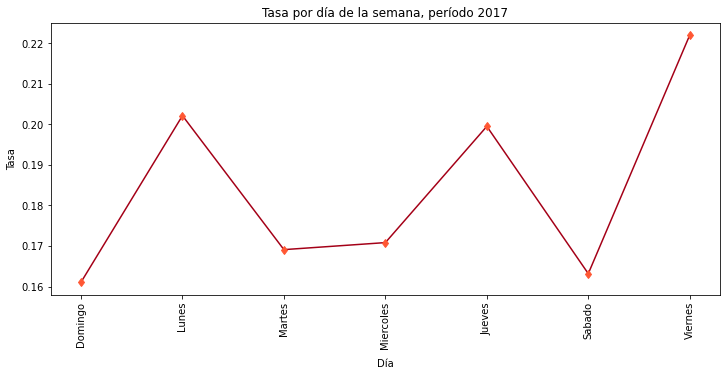

In [133]:
plt.figure(figsize=(12,5))
plt.plot(dia_tasa['Día'],dia_tasa['Tasa'],marker='d',linestyle='-', c = '#a40017',markeredgecolor='#FF5733',markerfacecolor= '#FF5733')
plt.xticks(rotation = 90)
plt.xlabel('Día', labelpad=10)
plt.ylabel('Tasa')
plt.title('Tasa por día de la semana, período 2017')
plt.show()

In [134]:
temporada = data['temporada_alta'].unique().tolist()
valores, atrasos, cantidad_total = calculo_tasas(data, temporada,'temporada_alta')
temporada_tasa = pd.DataFrame({
    'temporada':temporada,
    'N Vuelos':cantidad_total,
    'N Vuelos atrasados':atrasos,
    'Tasa':valores
})

In [135]:
temporada_tasa

,temporada,N Vuelos,N Vuelos atrasados,Tasa
0,1,22761,4470,0.196389
1,0,45444,8144,0.179210


In [136]:
tipovuelo = data['TIPOVUELO'].unique().tolist()
valores, atrasos, cantidad_total = calculo_tasas(data, tipovuelo,'TIPOVUELO')
tipovuelo_tasa = pd.DataFrame({
    'Tipo de Vuelo':tipovuelo,
    'N Vuelos':cantidad_total,
    'N Vuelos atrasados':atrasos,
    'Tasa':valores
})

In [137]:
tipovuelo_tasa

,Tipo de Vuelo,N Vuelos,N Vuelos atrasados,Tasa
0,I,31239,7048,0.225615
1,N,36966,5566,0.150571


En base al previo analisis de las tasas de los vuelos, se puede considerar que las variables mas influyentes en la predicción del modelo podrían ser el destino programado, la aerolinea del vuelo, el mes en el que se programa el vuelo y el dia de la semana en que se pograma el vuelo. Por su parte la variable temporada que se esperaria afectara en gran manera al atraso de un vuelo no posee un gran impacto, dado que las tasas se mantienen estables en los diferentes periodos en donde se encuentra una temporada alta. No obstante si se puede observar que en los meses de pertenecientes a invierno se observan tasas mayores lo que si podría indicar que el clima es bastante incidente en el atraso de un vuelo. 


# Modelos 

In [237]:
# Definimos las variables que vamos a utilizar para el modelo predictivo

datos = data[['atraso_15', 'DIA', 'MES', 'DIANOM',
       'OPERA', 'SIGLADES', 'TIPOVUELO','holiday','temporada_alta', 'periodo_dia']]

In [238]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   atraso_15       68206 non-null  bool  
 1   DIA             68206 non-null  int64 
 2   MES             68206 non-null  int64 
 3   DIANOM          68206 non-null  object
 4   OPERA           68206 non-null  object
 5   SIGLADES        68206 non-null  object
 6   TIPOVUELO       68206 non-null  object
 7   holiday         68206 non-null  int32 
 8   temporada_alta  68206 non-null  int32 
 9   periodo_dia     68206 non-null  object
dtypes: bool(1), int32(2), int64(2), object(5)
memory usage: 4.2+ MB


In [239]:
#from imblearn.over_sampling import SMOTE -- Se descarta por poco impacto en resultados.
#pip install imblearn

#Selección de variable objetivo.

y= datos["atraso_15"]
X= datos.drop(columns=['atraso_15'])


Transformación a conjunto entrenamiento y prueba, junto con la transformación de las variables categoricas.

In [240]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)

categoricas= X_train.select_dtypes(include=['object','category']).columns.to_list()
numericas= X_train.select_dtypes(include=['int64','category']).columns.to_list()

In [241]:
columnTransformer = ColumnTransformer([("encoder", OneHotEncoder(handle_unknown = 'ignore'),categoricas)],remainder="passthrough")

X_train=columnTransformer.fit_transform(X_train)
X_test=columnTransformer.transform(X_test)

encoded=columnTransformer.named_transformers_['encoder'].get_feature_names(categoricas)

C:\Users\mbustamf\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Primer modelo Regresión logistica. 

In [242]:
#Instantizing Model
lr_model_final = LogisticRegression(C=1.0,n_jobs=-1,verbose=1, random_state=154)

#training
lr_model_final.fit(X_train, y_train)
print_score(lr_model_final, X_train, y_train, X_test, y_test,"Logistic Regression", train=False,add=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Data test:

Precision ---> 81.55116801876649 %
Reporte completo
                   False         True  accuracy     macro avg  weighted avg
precision      0.817917     0.586854  0.815512      0.702386      0.774871
recall         0.994715     0.032791  0.815512      0.513753      0.815512
f1-score       0.897694     0.062112  0.815512      0.479903      0.742028
support    16650.000000  3812.000000  0.815512  20462.000000  20462.000000
Matriz de confusión:
 [[16562    88]
 [ 3687   125]]
Roc score ---> 0.5137529502219953
Acc score ---> 0.815511680187665


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


### Segundo modelo Decision Tree. 

In [243]:
DecisionTreeClassifierModel = DecisionTreeClassifier(criterion='entropy',max_depth=16,random_state=40)
DecisionTreeClassifierModel.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=16, random_state=40)

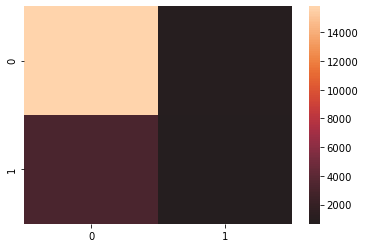

Confusion Matrix is
 [[15810   840]
 [ 3152   660]]
Data test:

Precision ---> 80.49066562408368 %
Reporte completo
                   False         True  accuracy     macro avg  weighted avg
precision      0.833773     0.440000  0.804907      0.636886      0.760414
recall         0.949550     0.173137  0.804907      0.561344      0.804907
f1-score       0.887903     0.248494  0.804907      0.568198      0.768783
support    16650.000000  3812.000000  0.804907  20462.000000  20462.000000
Matriz de confusión:
 [[15810   840]
 [ 3152   660]]
Roc score ---> 0.5613435051000634
Acc score ---> 0.8049066562408367
DecisionTreeClassifierModel Test Score is :  0.8049066562408367


In [244]:
y_pred_DT = DecisionTreeClassifierModel.predict(X_test)

CM_DT = confusion_matrix(y_test, y_pred_DT)
sns.heatmap(CM_DT, center=True)
plt.show()

print('Confusion Matrix is\n', CM_DT)
print_score(DecisionTreeClassifierModel, X_train, y_train, X_test, y_test,"Decision Tree", train=False,add=True)
print('DecisionTreeClassifierModel Test Score is : ' , DecisionTreeClassifierModel.score(X_test, y_test))

### Tercer modelo Random Forest. 

In [245]:
RandomForestClassifierModel = RandomForestClassifier(criterion = 'entropy', max_depth=18, n_estimators=400, random_state=44)
RandomForestClassifierModel.fit(X_train, y_train)

print('RandomForestClassifierModel Train Score is : ' , RandomForestClassifierModel.score(X_train, y_train))
print('RandomForestClassifierModel Test Score is : ' , RandomForestClassifierModel.score(X_test, y_test))

RandomForestClassifierModel Train Score is :  0.840063672922252
RandomForestClassifierModel Test Score is :  0.8177108787019841


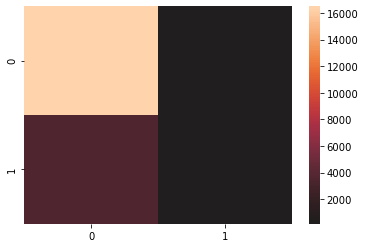

Confusion Matrix is
 [[16501   149]
 [ 3581   231]]
Data test:

Precision ---> 81.77108787019841 %
Reporte completo
                   False         True  accuracy     macro avg  weighted avg
precision      0.821681     0.607895  0.817711      0.714788      0.781853
recall         0.991051     0.060598  0.817711      0.525825      0.817711
f1-score       0.898454     0.110210  0.817711      0.504332      0.751607
support    16650.000000  3812.000000  0.817711  20462.000000  20462.000000
Matriz de confusión:
 [[16501   149]
 [ 3581   231]]
Roc score ---> 0.5258245811393766
Acc score ---> 0.8177108787019841


In [246]:
y_pred_RF = RandomForestClassifierModel.predict(X_test)
CM_RF = confusion_matrix(y_test, y_pred_RF)

sns.heatmap(CM_RF, center=True)
plt.show()

print('Confusion Matrix is\n', CM_RF)
print_score(RandomForestClassifierModel, X_train, y_train, X_test, y_test,"Random Forest", train=False,add=True)

## 4to modelo XGB

In [249]:
gb = GradientBoostingClassifier(max_depth = 18 , n_estimators= 6)
gb.fit(X_train , y_train)

GradientBoostingClassifier(max_depth=18, n_estimators=6)

In [250]:
print_score(gb, X_train, y_train, X_test, y_test,"Gradient Boost",train=True,add=False)

print_score(gb, X_train, y_train, X_test, y_test,"Gradient Boost",train=False,add=True)

Data entrenamiento:

Precision ---> 87.06853217158177 %
Reporte completo
                   False         True  accuracy     macro avg  weighted avg
precision      0.863201     0.998861  0.870685      0.931031      0.888211
recall         0.999923     0.298909  0.870685      0.649416      0.870685
f1-score       0.926545     0.460126  0.870685      0.693336      0.840557
support    38942.000000  8802.000000  0.870685  47744.000000  47744.000000
Matriz de confusión:
 [[38939     3]
 [ 6171  2631]]
Roc score ---> 0.6494161505704549
Acc score ---> 0.8706853217158177
Data test:

Precision ---> 80.51510116313166 %
Reporte completo
                   False         True  accuracy     macro avg  weighted avg
precision      0.829131     0.428571  0.805151      0.628851      0.754508
recall         0.957958     0.137723  0.805151      0.547840      0.805151
f1-score       0.888901     0.208457  0.805151      0.548679      0.762137
support    16650.000000  3812.000000  0.805151  20462.000000  204

In [251]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(seed=17)

xgb_model.fit(X_train, y_train)
xgb_valid_pred = xgb_model.predict_proba(X_test)[:, 1]

roc_auc_score(y_test, xgb_valid_pred)



0.7233481435265275

In [252]:
print_score(xgb_model, X_train, y_train, X_test, y_test,"XGBClassifier",train=False,add=True)

Data test:

Precision ---> 82.29889551363503 %
Reporte completo
                   False         True  accuracy     macro avg  weighted avg
precision      0.832890     0.606264  0.822989      0.719577      0.790671
recall         0.978859     0.142183  0.822989      0.560521      0.822989
f1-score       0.899994     0.230344  0.822989      0.565169      0.775241
support    16650.000000  3812.000000  0.822989  20462.000000  20462.000000
Matriz de confusión:
 [[16298   352]
 [ 3270   542]]
Roc score ---> 0.5605207200904998
Acc score ---> 0.8229889551363503


## Hyperparameter tuning Decisision Tree Gridsearch

In [253]:
from sklearn.model_selection import GridSearchCV
params = {
    "criterion":("gini", "entropy"), 
    "splitter":("best", "random"), 
    "max_depth":(list(range(10, 15))),
    "min_samples_split":[ 3, 4, 5,6], 
    "min_samples_leaf":list(range(10, 15)),     
    }

tree_clf = DecisionTreeClassifier(random_state=0)
tree_cv = GridSearchCV(tree_clf, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
tree_cv.fit(X_train, y_train)

best_params = tree_cv.best_params_
print("Best paramters:",best_params)
tree_clf = DecisionTreeClassifier(**best_params)
tree_clf.fit(X_train, y_train)

Fitting 3 folds for each of 400 candidates, totalling 1200 fits
Best paramters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 13, 'min_samples_split': 3, 'splitter': 'best'}


DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=13,
                       min_samples_split=3)

In [254]:
print_score(tree_clf, X_train, y_train, X_test, y_test,"nn",train=True,add=False)
print_score(tree_clf, X_train, y_train, X_test, y_test,"DT_gridsearch",train=False,add=True)

Data entrenamiento:

Precision ---> 82.82087801608579 %
Reporte completo
                   False         True  accuracy     macro avg  weighted avg
precision      0.832770     0.692802  0.828209      0.762786      0.806966
recall         0.987725     0.122472  0.828209      0.555099      0.828209
f1-score       0.903653     0.208148  0.828209      0.555901      0.775431
support    38942.000000  8802.000000  0.828209  47744.000000  47744.000000
Matriz de confusión:
 [[38464   478]
 [ 7724  1078]]
Roc score ---> 0.5550987502653548
Acc score ---> 0.8282087801608579
Data test:

Precision ---> 82.17671781839508 %
Reporte completo
                   False         True  accuracy     macro avg  weighted avg
precision      0.828873     0.619048  0.821767      0.723961      0.789784
recall         0.984144     0.112539  0.821767      0.548342      0.821767
f1-score       0.899860     0.190455  0.821767      0.545158      0.767700
support    16650.000000  3812.000000  0.821767  20462.000000  204

# Hyperparameter tuning XGB

In [285]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import xgboost as xgb

def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [286]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)



  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                 
0.8137034502981135                                     
  1%|          | 1/100 [00:00<00:20,  4.84trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.8137034502981135                                                                
  2%|▏         | 2/100 [00:00<00:20,  4.76trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.8137034502981135                                                                
  3%|▎         | 3/100 [00:00<00:20,  4.69trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.8137034502981135                                                                
  4%|▍         | 4/100 [00:00<00:20,  4.72trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.8137034502981135                                                                
  5%|▌         | 5/100 [00:01<00:20,  4.69trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.8137034502981135                                                                
  6%|▌         | 6/100 [00:01<00:20,  4.69trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.8137034502981135                                                                
  7%|▋         | 7/100 [00:01<00:19,  4.67trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.8137034502981135                                                                
  8%|▊         | 8/100 [00:01<00:19,  4.62trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.8137034502981135                                                                
  9%|▉         | 9/100 [00:02<00:38,  2.35trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.8137034502981135                                                                
 10%|█         | 10/100 [00:02<00:32,  2.78trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 11%|█         | 11/100 [00:03<00:27,  3.19trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 12%|█▏        | 12/100 [00:03<00:24,  3.53trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 13%|█▎        | 13/100 [00:03<00:23,  3.70trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 14%|█▍        | 14/100 [00:03<00:22,  3.84trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 15%|█▌        | 15/100 [00:03<00:21,  3.92trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 16%|█▌        | 16/100 [00:04<00:20,  4.02trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 17%|█▋        | 17/100 [00:04<00:20,  4.03trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 18%|█▊        | 18/100 [00:04<00:20,  4.09trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 19%|█▉        | 19/100 [00:04<00:19,  4.16trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 20%|██        | 20/100 [00:05<00:19,  4.21trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 21%|██        | 21/100 [00:05<00:19,  4.05trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 22%|██▏       | 22/100 [00:05<00:19,  4.08trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 23%|██▎       | 23/100 [00:05<00:18,  4.09trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 24%|██▍       | 24/100 [00:06<00:18,  4.14trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 25%|██▌       | 25/100 [00:06<00:18,  4.16trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 26%|██▌       | 26/100 [00:06<00:17,  4.18trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 27%|██▋       | 27/100 [00:06<00:17,  4.20trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 28%|██▊       | 28/100 [00:07<00:17,  4.21trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 29%|██▉       | 29/100 [00:07<00:16,  4.19trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 30%|███       | 30/100 [00:07<00:16,  4.19trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 31%|███       | 31/100 [00:07<00:16,  4.22trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 32%|███▏      | 32/100 [00:08<00:16,  4.25trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 33%|███▎      | 33/100 [00:08<00:15,  4.25trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 34%|███▍      | 34/100 [00:08<00:15,  4.22trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 35%|███▌      | 35/100 [00:08<00:17,  3.64trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 36%|███▌      | 36/100 [00:09<00:17,  3.69trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 37%|███▋      | 37/100 [00:09<00:16,  3.88trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 38%|███▊      | 38/100 [00:09<00:15,  3.94trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 39%|███▉      | 39/100 [00:09<00:15,  4.06trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 40%|████      | 40/100 [00:10<00:14,  4.20trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 41%|████      | 41/100 [00:10<00:13,  4.28trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 42%|████▏     | 42/100 [00:10<00:13,  4.23trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 43%|████▎     | 43/100 [00:10<00:13,  4.28trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 44%|████▍     | 44/100 [00:10<00:13,  4.29trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 45%|████▌     | 45/100 [00:11<00:12,  4.37trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 46%|████▌     | 46/100 [00:11<00:12,  4.44trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 47%|████▋     | 47/100 [00:11<00:11,  4.48trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 48%|████▊     | 48/100 [00:11<00:11,  4.49trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 49%|████▉     | 49/100 [00:12<00:11,  4.49trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 50%|█████     | 50/100 [00:12<00:12,  4.08trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 51%|█████     | 51/100 [00:12<00:11,  4.19trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 52%|█████▏    | 52/100 [00:12<00:11,  4.26trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 53%|█████▎    | 53/100 [00:13<00:11,  4.25trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 54%|█████▍    | 54/100 [00:13<00:10,  4.31trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 55%|█████▌    | 55/100 [00:13<00:10,  4.25trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 56%|█████▌    | 56/100 [00:13<00:10,  4.29trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 57%|█████▋    | 57/100 [00:13<00:10,  4.27trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 58%|█████▊    | 58/100 [00:14<00:09,  4.24trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 59%|█████▉    | 59/100 [00:14<00:09,  4.27trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 60%|██████    | 60/100 [00:14<00:09,  4.31trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 61%|██████    | 61/100 [00:14<00:09,  4.27trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 62%|██████▏   | 62/100 [00:15<00:08,  4.35trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 63%|██████▎   | 63/100 [00:15<00:08,  4.35trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 64%|██████▍   | 64/100 [00:15<00:08,  4.38trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 65%|██████▌   | 65/100 [00:15<00:08,  4.36trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 66%|██████▌   | 66/100 [00:16<00:07,  4.30trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 67%|██████▋   | 67/100 [00:16<00:07,  4.31trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 68%|██████▊   | 68/100 [00:16<00:07,  4.37trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 69%|██████▉   | 69/100 [00:16<00:07,  4.27trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 70%|███████   | 70/100 [00:16<00:07,  4.27trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 71%|███████   | 71/100 [00:17<00:06,  4.32trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 72%|███████▏  | 72/100 [00:17<00:06,  4.34trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 73%|███████▎  | 73/100 [00:17<00:06,  4.26trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 74%|███████▍  | 74/100 [00:17<00:06,  4.24trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 75%|███████▌  | 75/100 [00:18<00:06,  4.12trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 76%|███████▌  | 76/100 [00:18<00:05,  4.12trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 77%|███████▋  | 77/100 [00:18<00:05,  4.10trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 78%|███████▊  | 78/100 [00:18<00:05,  4.17trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 79%|███████▉  | 79/100 [00:19<00:04,  4.21trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 80%|████████  | 80/100 [00:19<00:04,  4.23trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 81%|████████  | 81/100 [00:19<00:04,  4.25trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 82%|████████▏ | 82/100 [00:19<00:04,  4.21trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 83%|████████▎ | 83/100 [00:20<00:04,  4.08trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 84%|████████▍ | 84/100 [00:20<00:04,  3.99trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 85%|████████▌ | 85/100 [00:20<00:03,  3.99trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 86%|████████▌ | 86/100 [00:20<00:03,  4.06trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 87%|████████▋ | 87/100 [00:21<00:03,  4.04trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 88%|████████▊ | 88/100 [00:21<00:02,  4.11trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 89%|████████▉ | 89/100 [00:21<00:02,  4.14trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 90%|█████████ | 90/100 [00:21<00:02,  4.12trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 91%|█████████ | 91/100 [00:22<00:02,  4.06trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 92%|█████████▏| 92/100 [00:22<00:01,  4.02trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 93%|█████████▎| 93/100 [00:22<00:01,  4.01trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 94%|█████████▍| 94/100 [00:23<00:02,  2.80trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 95%|█████████▌| 95/100 [00:23<00:01,  3.12trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 96%|█████████▌| 96/100 [00:23<00:01,  3.40trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 97%|█████████▋| 97/100 [00:23<00:00,  3.62trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 98%|█████████▊| 98/100 [00:24<00:00,  3.80trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
 99%|█████████▉| 99/100 [00:24<00:00,  3.92trial/s, best loss: -0.8137034502981135]

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\mbustamf\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.8137034502981135                                                                 
100%|██████████| 100/100 [00:24<00:00,  4.07trial/s, best loss: -0.8137034502981135]


In [287]:
print("Los mejores hypermarametros son: ","\n")
print(best_hyperparams)

Los mejores hypermarametros son:  

{'colsample_bytree': 0.9892403831077343, 'gamma': 1.8528490488310299, 'max_depth': 4.0, 'min_child_weight': 9.0, 'reg_alpha': 116.0, 'reg_lambda': 0.7541916569636499}


In [288]:
clf=XGBClassifier(n_estimators =180, max_depth = 7, gamma = 1.7679696104338376,
                    reg_alpha = 4,min_child_weight=4,
                    colsample_bytree=int(0.8620285832468177))
    
clf.fit(X_train, y_train)
xgb_valid_pred = clf.predict_proba(X_test)[:, 1]

roc_auc_score(y_test, xgb_valid_pred)
    


0.666731098884824

In [289]:
print_score(clf, X_train, y_train, X_test, y_test,"XGBClassifier Hyp Tunn",train=False,add=False)

Data test:

Precision ---> 81.35568370638256 %
Reporte completo
                   False         True  accuracy     macro avg  weighted avg
precision      0.814352     0.468085  0.813557      0.641219      0.749844
recall         0.998498     0.005771  0.813557      0.502135      0.813557
f1-score       0.897073     0.011402  0.813557      0.454237      0.732075
support    16650.000000  3812.000000  0.813557  20462.000000  20462.000000
Matriz de confusión:
 [[16625    25]
 [ 3790    22]]
Roc score ---> 0.5021348735934256
Acc score ---> 0.8135568370638256


A continuación se presenta una tabla resumen de los resultados obtenidos por modelo, cabe destacar que cada puntaje indicado es con respecto al conjunto de test y no el de entrenamiento.

In [290]:
from tabulate import tabulate
log[1:] = sorted(log[1:])
print(tabulate(log, headers='firstrow', tablefmt='fancy_grid'))

╒════════════════════════╤═════════════╤══════════╕
│ Modelo                 │   Precision │      Roc │
╞════════════════════════╪═════════════╪══════════╡
│ DT_gridsearch          │     82.1767 │ 0.548342 │
├────────────────────────┼─────────────┼──────────┤
│ Decision Tree          │     80.4907 │ 0.561344 │
├────────────────────────┼─────────────┼──────────┤
│ Gradient Boost         │     80.5151 │ 0.54784  │
├────────────────────────┼─────────────┼──────────┤
│ Logistic Regression    │     81.5512 │ 0.513753 │
├────────────────────────┼─────────────┼──────────┤
│ Random Forest          │     81.7711 │ 0.525825 │
├────────────────────────┼─────────────┼──────────┤
│ XGBClassifier          │     82.2989 │ 0.560521 │
├────────────────────────┼─────────────┼──────────┤
│ XGBClassifier Hyp Tunn │     81.3557 │ 0.502135 │
╘════════════════════════╧═════════════╧══════════╛


# Conclusiones Finales

Comparando la precisión de los modelos testeados el que entrego mejor resultado fue XGBClassifier junto Decision Tree, el cual este último al recibir una optimización de parametros recibio un leve mejoramiento en su precisión. Contrario al caso de XGB que al recibir optimización de parametros su variacion fue levemente negativa. No obstante los resultados en torno a la precisión ROC score de ambos no son muy altos.

Una causa con respecto a la deficiencia de la precisión puede darse por las pocas variables que se tienen en torno a las caracteristicas de los vuelos, estas variables solo estan enfocadas en factores sobre los vuelos que se atrasan y no caracteristicas mas relevantes que puedan afectar a los vuelos. Como lo serían las condiciones climatologicas, distancia, la separación de hora de llegada con la hora de salida, si el vuelo tuvo mas de un destino (escalas), tipos de pasajeros (se ha notado como en ciertos casos vuelos con gente que se encuentra en situaciones de discapacidad etc.

Para un mejoramiento del modelo en un futuro se propone aumentar la información que se tiene alrededor de los vuelos, de esta manera se podría generar un mejor estudio.
